In [ ]:
4# IMPORT LIBRARIES==
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")


In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.2 MB/s eta 0:00:00


In [ ]:
# LOAD & PREPROCESS DATA ===
df = pd.read_csv("/content/POWER_Point_Hourly_20200101_20241231_034d15N_077d58E_LST.csv", skiprows=range(0, 15), header=0, comment='#')
df = df.rename(columns={'2020': 'Year', '1': 'Month', '1.1': 'Day'})
df["DATE"] = pd.to_datetime(df[["Year", "Month", "Day"]])
df.replace(-999, np.nan, inplace=True)
print(df.columns)
# df["Clearness_Index"] = df["Clearness_Index"].replace(0, np.nan)

Index(['Year', 'Month', 'Day', '0', '0.0', '0.0.1', '0.0.2', '-25.84', '93.01',
       '2.04', 'DATE'],
      dtype='object')


In [ ]:
# AGGREGATE TO DAILY ==
def aggregate_daily(data):
    daily_data = data.groupby("DATE").agg({
        "0.0": lambda x: x.sum() / 1000,  # Assuming '0.0' is Irradiation
        "-25.84": "mean",  # Assuming '-25.84' is Temperature
        "93.01": "mean",  # Assuming '93.01' is RH
        "2.04": "mean",  # Assuming '2.04' is Wind_ Speed
        "0.0.1": "mean",  # Assuming '0.0.1' is Clearness_Index
        "0.0.2": "mean",  # Assuming '0.0.2' is Pressure
        "0": "mean"  # Assuming '0' is Precipitiation
    }).reset_index()
    return daily_data.dropna()

daily_df = aggregate_daily(df)

In [ ]:
# SPLIT FEATURES AND TARGET ===
X = daily_df.drop(columns=["DATE", "0.0"])
y = daily_df["0.0"].values.ravel()

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [ ]:
# INDIVIDUAL ALGORITHM EVALUATIONS ==

def evaluate_model(name, model, xtr, xts, ytr, yts):
    model.fit(xtr, ytr)
    y_pred_train = model.predict(xtr)
    y_pred_test = model.predict(xts)
    print(f"\n🔹 {name}")
    print(f"Train R²: {r2_score(ytr, y_pred_train):.4f}")
    print(f"Test R² : {r2_score(yts, y_pred_test):.4f}")
    print(f"Test RMSE: {np.sqrt(mean_squared_error(yts, y_pred_test)):.4f}")
    print(f"Test MAE : {mean_absolute_error(yts, y_pred_test):.4f}")
    return model

In [ ]:
# 1. Linear Regression
evaluate_model("Linear Regression", LinearRegression(), x_train_scaled, x_test_scaled, y_train, y_test)


🔹 Linear Regression
Train R²: 0.9643
Test R² : 0.9635
Test RMSE: 0.3662
Test MAE : 0.2751


LinearRegression()

In [ ]:
# 2. Decision Tree
evaluate_model("Decision Tree", DecisionTreeRegressor(max_depth=5, random_state=42), x_train_scaled, x_test_scaled, y_train, y_test)



🔹 Decision Tree
Train R²: 0.9375
Test R² : 0.9027
Test RMSE: 0.5977
Test MAE : 0.4631


DecisionTreeRegressor(max_depth=5, random_state=42)

In [ ]:
# 3. Random Forest
evaluate_model("Random Forest", RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42), x_train_scaled, x_test_scaled, y_train, y_test)


🔹 Random Forest
Train R²: 0.9963
Test R² : 0.9818
Test RMSE: 0.2589
Test MAE : 0.1972


RandomForestRegressor(max_depth=10, random_state=42)

In [ ]:
# 4. LightGBM
evaluate_model("LightGBM", LGBMRegressor(), x_train_scaled, x_test_scaled, y_train, y_test)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 1338, number of used features: 5
[LightGBM] [Info] Start training from score 5.126474

🔹 LightGBM
Train R²: 0.9960
Test R² : 0.9809
Test RMSE: 0.2649
Test MAE : 0.2029


LGBMRegressor()

In [ ]:
# 5. XGBoost
evaluate_model("XGBoost", XGBRegressor(n_estimators=100, max_depth=5, random_state=42), x_train_scaled, x_test_scaled, y_train, y_test)


🔹 XGBoost
Train R²: 0.9989
Test R² : 0.9768
Test RMSE: 0.2921
Test MAE : 0.2239


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
# 6. CatBoost
evaluate_model("CatBoost", CatBoostRegressor(iterations=100, learning_rate=0.1, depth=5, verbose=0), x_train_scaled, x_test_scaled, y_train, y_test)


🔹 CatBoost
Train R²: 0.9890
Test R² : 0.9851
Test RMSE: 0.2343
Test MAE : 0.1757


In [ ]:
# ARIMAX TIME SERIES MODEL ==
arimax_df = daily_df.copy()
arimax_df.set_index("DATE", inplace=True)

y_arima = arimax_df["0.0"]
exog_arima = arimax_df.drop(columns=["0.0"])

train_size = int(len(y_arima) * 0.8)
y_train_arima, y_test_arima = y_arima[:train_size], y_arima[train_size:]
exog_train_arima, exog_test_arima = exog_arima[:train_size], exog_arima[train_size:]

model_arima = SARIMAX(y_train_arima, exog=exog_train_arima, order=(2,1,2), seasonal_order=(1,0,1,7),
                      enforce_stationarity=False, enforce_invertibility=False)
fit_arima = model_arima.fit(disp=False)

pred_arima = fit_arima.forecast(steps=len(y_test_arima), exog=exog_test_arima)

In [ ]:
# Evaluation
print("\n🔹 ARIMAX (Time Series)")
print(f"R² Score: {r2_score(y_test_arima, pred_arima):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_arima, pred_arima)):.4f}")
print(f"MAE: {mean_absolute_error(y_test_arima, pred_arima):.4f}")


🔹 ARIMAX (Time Series)
R² Score: 0.9027
RMSE: 0.5999
MAE: 0.5022


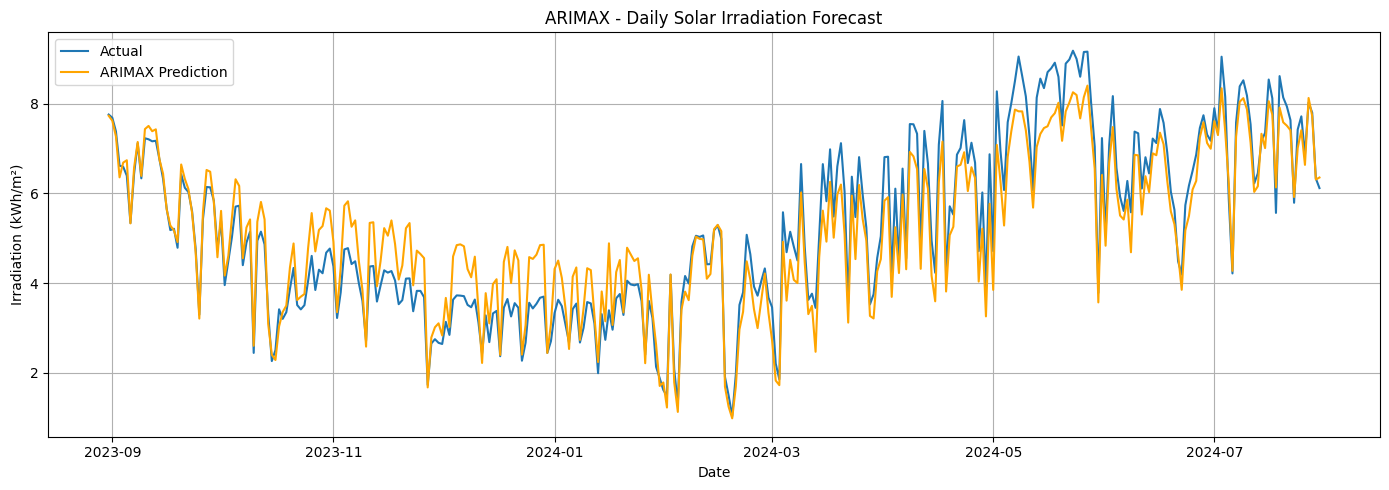

In [ ]:
# Plot==
plt.figure(figsize=(14, 5))
plt.plot(y_test_arima.index, y_test_arima, label="Actual")
plt.plot(y_test_arima.index, pred_arima, label="ARIMAX Prediction", color='orange')
plt.title("ARIMAX - Daily Solar Irradiation Forecast")
plt.xlabel("Date")
plt.ylabel("Irradiation (kWh/m²)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# INDIVIDUAL MODEL TRAINING & EVALUATION (OPTIONAL)=====
model_scores = {}
test_predictions = {}

def evaluate_model(name, model):
    model.fit(x_train_scaled, y_train)
    y_pred_test = model.predict(x_test_scaled)
    test_predictions[name] = y_pred_test
    model_scores[name] = r2_score(y_test, y_pred_test)
    print(f"\n🔹 {name}")
    print(f"R² Score: {model_scores[name]:.4f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_test)):.4f}")
    print(f"MAE : {mean_absolute_error(y_test, y_pred_test):.4f}")
    return model

In [ ]:
# FUTURE FORECAST (NEXT 7 DAYS) ===
last_exog = exog_arima.iloc[-1:]
future_exog = pd.concat([last_exog] * 7, ignore_index=True)

future_forecast = fit_arima.forecast(steps=7, exog=future_exog)
future_dates = pd.date_range(start=arimax_df.index[-1] + pd.Timedelta(days=1), periods=7)

future_df = pd.DataFrame({
    "Date": future_dates,
    "Forecast_Irradiation": future_forecast.values
})
print("\n📅 Future Forecast (Next 7 Days):")
print(future_df)


📅 Future Forecast (Next 7 Days):
        Date  Forecast_Irradiation
0 2024-07-31              6.421715
1 2024-08-01              6.392492
2 2024-08-02              6.367598
3 2024-08-03              6.347361
4 2024-08-04              6.358395
5 2024-08-05              6.346147
6 2024-08-06              6.346556


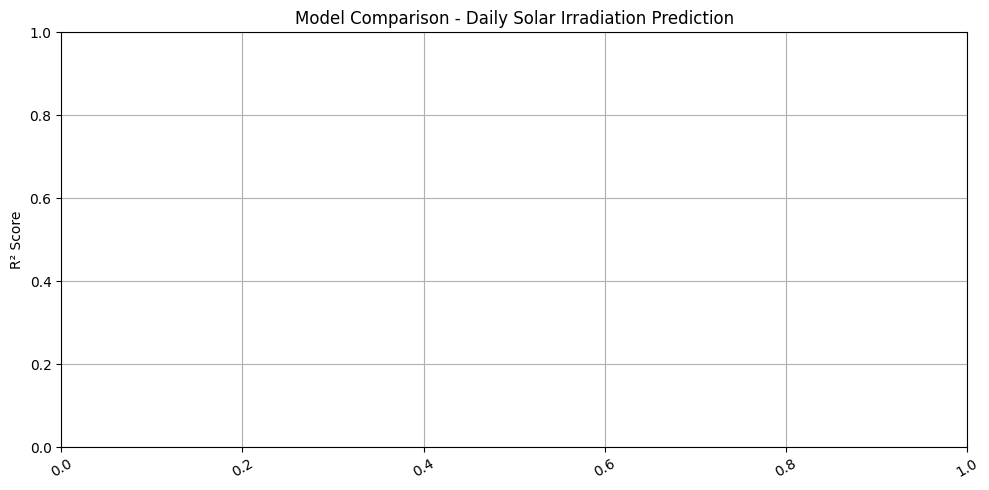

In [ ]:
# BAR PLOT FOR MODEL COMPARISON ==
plt.figure(figsize=(10, 5))
sns.barplot(x=list(model_scores.keys()), y=list(model_scores.values()), palette='viridis')
plt.ylabel("R² Score")
plt.title("Model Comparison - Daily Solar Irradiation Prediction")
plt.xticks(rotation=30)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
#  Load and Combine Data =================
df = pd.read_csv("/content/POWER_Point_Hourly_20200101_20241231_034d15N_077d58E_LST.csv", skiprows=range(0, 15), header=0, comment='#')
df = df.rename(columns={'2020': 'Year', '1': 'Month', '1.1': 'Day', '0': 'Hour', '0.0': 'Irradiation', '-25.84': 'Temperature', '93.01': 'RH', '2.04': 'Wind_Speed', '0.0.1': 'Clearness_Index', '0.0.2': 'Pressure'})
df["Datetime"] = pd.to_datetime(df[["Year", "Month", "Day", "Hour"]])
df = df[df["Irradiation"] >= 0]
df = df[(df["Hour"] >= 6) & (df["Hour"] <= 17)]  # Keep only 6AM to 5PM
df.replace(-999, np.nan, inplace=True)
df["Clearness_Index"] = df["Clearness_Index"].replace(0, np.nan)
df.dropna(inplace=True)

In [ ]:
#  Filter for 6 AM to 5 PM(17) only =================
df = df[df["Hour"].between(6, 17)]


In [ ]:
#  Remove invalid values =================
df = df[df["Irradiation"] >= 0]
df.replace(-999, np.nan, inplace=True)

In [ ]:
#  Create datetime index =================
df["Datetime"] = pd.to_datetime(df[["Year", "Month", "Day", "Hour"]])
df.set_index("Datetime", inplace=True)
df = df.asfreq("H").fillna(method="ffill")

In [ ]:
#Train-test split =================
train_size = int(len(df) * 0.8)
y_train, y_test = target[:train_size], target[train_size:]
exog_train, exog_test = exog[:train_size], exog[train_size:]



In [ ]:
#  Fit ARIMAX model =================
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(y_train,
                exog=exog_train,
                order=(2, 1, 2),
                seasonal_order=(1, 0, 1, 12),
                enforce_stationarity=False,
                enforce_invertibility=False)
model_fit = model.fit(disp=False)

🔍 Correlation with Irradiation:
 Temperature    0.320788
RH            -0.286378
Pressure       0.839971
Wind_Speed     0.150255
Irradiation    1.000000
Name: Irradiation, dtype: float64

📊 ARIMAX Model Evaluation:
R² Score: 0.4647
RMSE: 194.4498
MAE: 150.9195


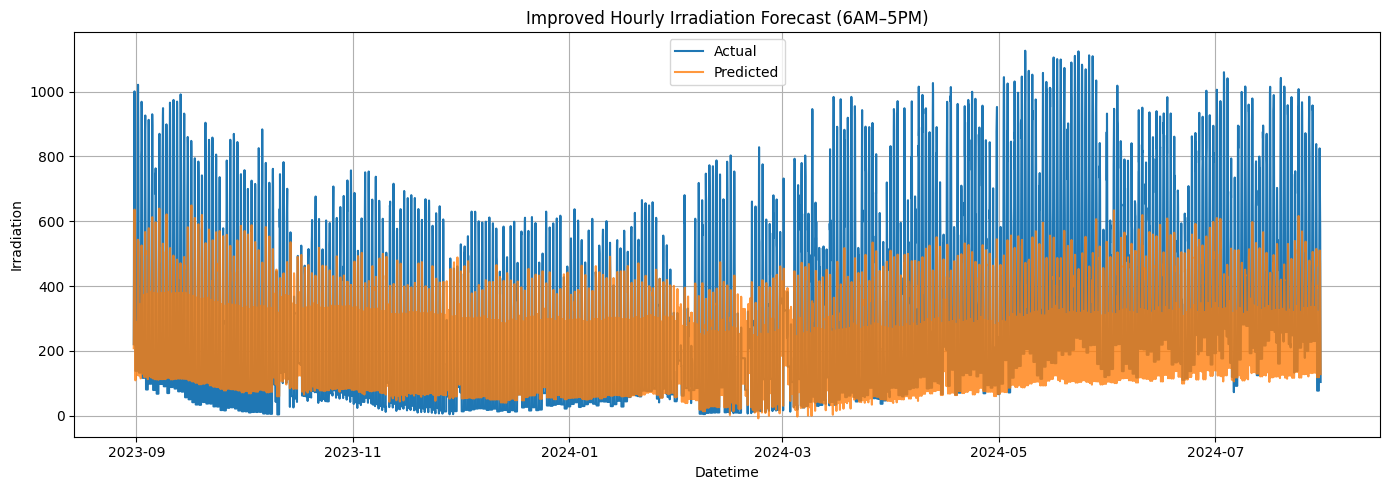

In [ ]:
#  Filter only useful daylight hours (6 to 17)
df = df[df['Hour'].between(6, 17)].copy() # Use .copy() to avoid SettingWithCopyWarning

# Remove invalid values
df = df[df["Irradiation"] >= 0].copy() # Use .copy()
df.replace(-999, np.nan, inplace=True)

#  Create datetime and set index, handle duplicates
df["Datetime"] = pd.to_datetime(df[["Year", "Month", "Day", "Hour"]])
df = df.drop_duplicates(subset=['Datetime']).set_index("Datetime") # Drop duplicates before setting index
df = df.asfreq("h").fillna(method="ffill") # Use 'h' for hourly frequency

# Feature selection (only well-correlated)
features = ["Temperature", "RH", "Pressure", "Wind_Speed"]
correlation = df[features + ["Irradiation"]].corr()
print("🔍 Correlation with Irradiation:\n", correlation["Irradiation"])

# Keep only features with good correlation
selected_features = correlation["Irradiation"].abs().sort_values(ascending=False)
selected_features = selected_features[selected_features > 0.2].index.drop("Irradiation").tolist()

#  Target and exogenous
target = df["Irradiation"]
exog = df[selected_features]

#Split into train/test
split = int(0.8 * len(df))
y_train, y_test = target[:split], target[split:]
exog_train, exog_test = exog[:split], exog[split:]

#  Tune ARIMA order (try different values!)
model = SARIMAX(y_train,
                exog=exog_train,
                order=(3, 0, 2),  # Try (3,0,2) or (2,0,2)
                seasonal_order=(1, 0, 1, 12),  # Daily seasonality
                enforce_stationarity=False,
                enforce_invertibility=False)
model_fit = model.fit(disp=False)

# Prediction
y_pred = model_fit.forecast(steps=len(y_test), exog=exog_test)

#  Metrics
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("\n📊 ARIMAX Model Evaluation:")
print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

# Plot
plt.figure(figsize=(14, 5))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred, label='Predicted', alpha=0.8)
plt.title("Improved Hourly Irradiation Forecast (6AM–5PM)")
plt.xlabel("Datetime")
plt.ylabel("Irradiation")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.1 MB/s eta 0:00:00



⏰ Hour: 6:00
✅ R² Score: -1.3250, RMSE: 171.88, MAE: 148.46


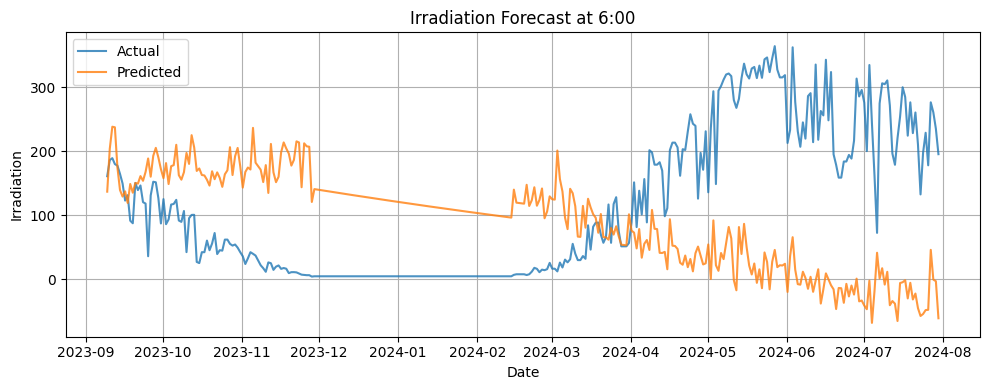


⏰ Hour: 7:00
✅ R² Score: -1.7012, RMSE: 257.67, MAE: 203.17


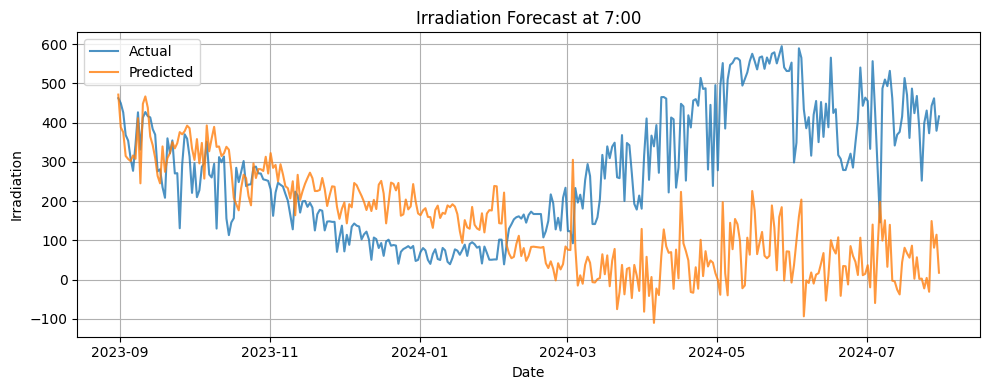


⏰ Hour: 8:00
✅ R² Score: -0.3678, RMSE: 196.10, MAE: 154.00


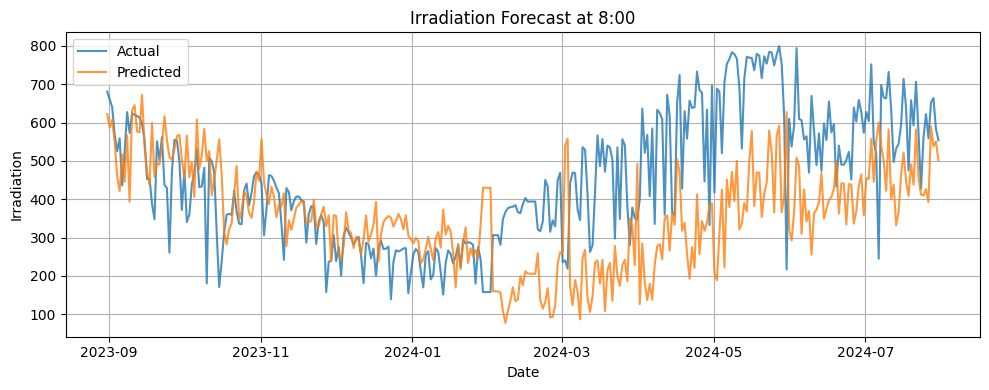


⏰ Hour: 9:00
✅ R² Score: -0.7318, RMSE: 241.84, MAE: 180.45


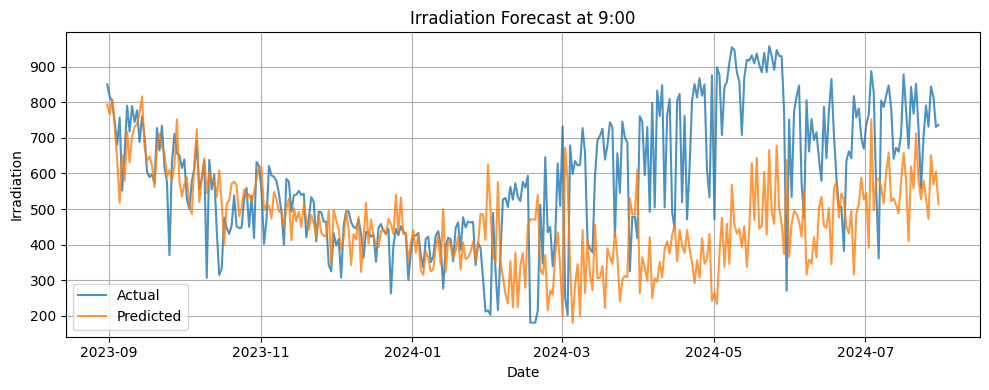


⏰ Hour: 10:00
✅ R² Score: -0.1458, RMSE: 203.62, MAE: 155.28


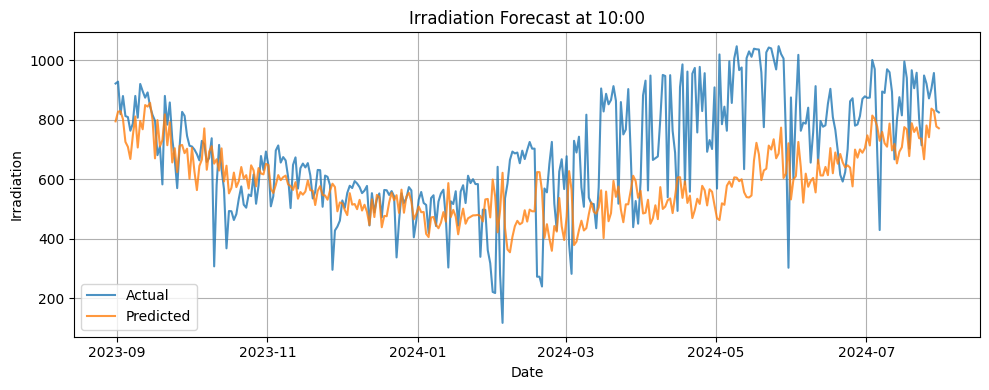


⏰ Hour: 11:00
✅ R² Score: -1.4469, RMSE: 318.46, MAE: 240.89


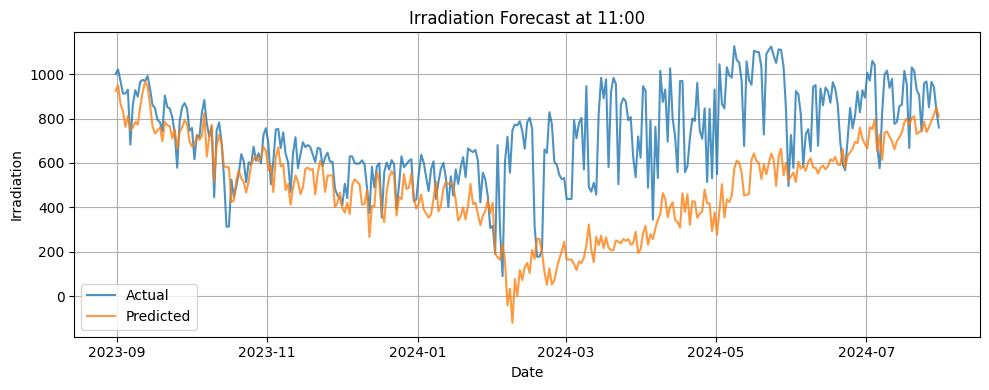


⏰ Hour: 12:00
✅ R² Score: 0.1112, RMSE: 198.27, MAE: 160.44


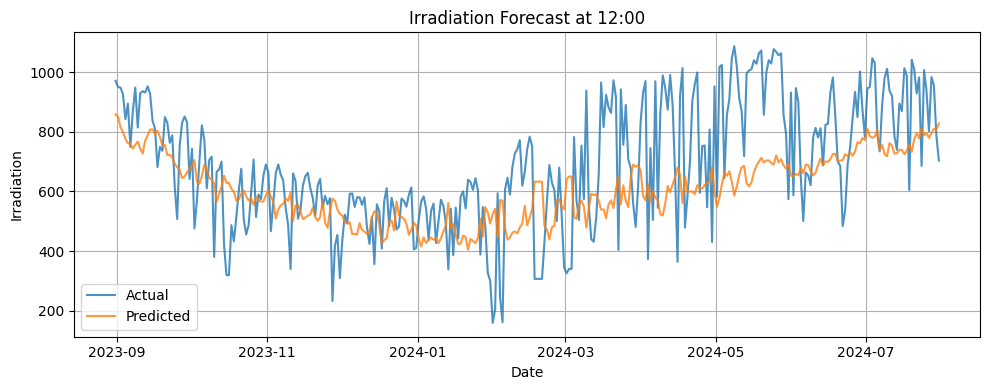


⏰ Hour: 13:00
✅ R² Score: -1.7476, RMSE: 340.47, MAE: 293.82


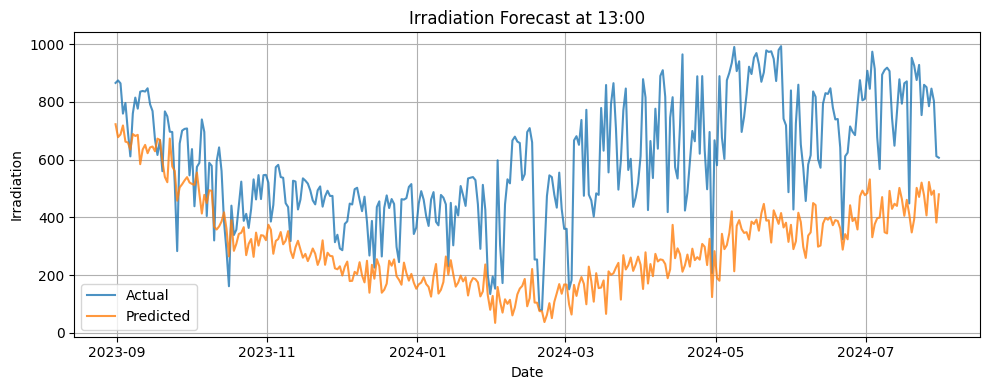


⏰ Hour: 14:00
✅ R² Score: 0.5733, RMSE: 118.26, MAE: 91.44


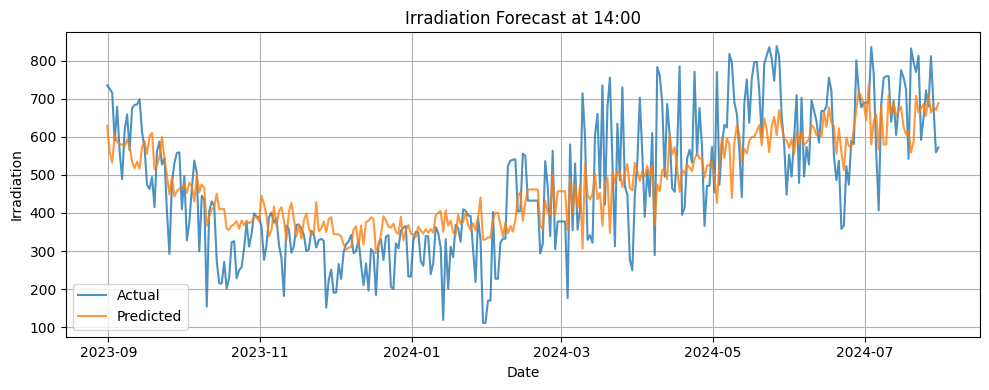


⏰ Hour: 15:00
✅ R² Score: -0.2145, RMSE: 178.89, MAE: 137.00


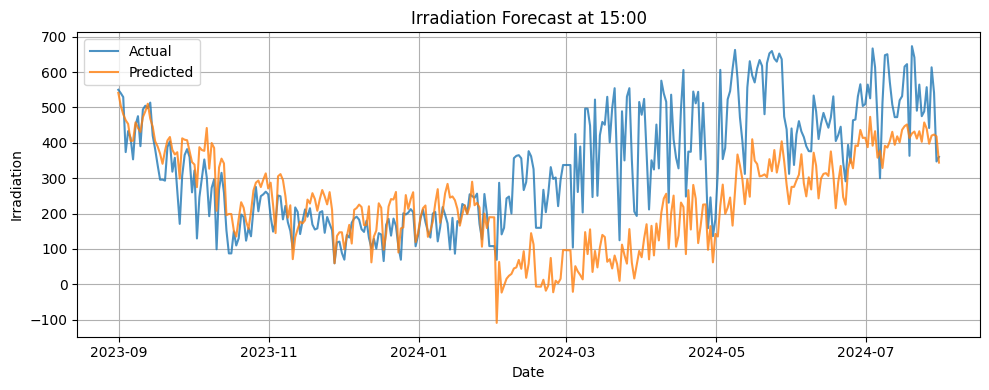


⏰ Hour: 16:00
✅ R² Score: 0.2358, RMSE: 114.70, MAE: 96.79


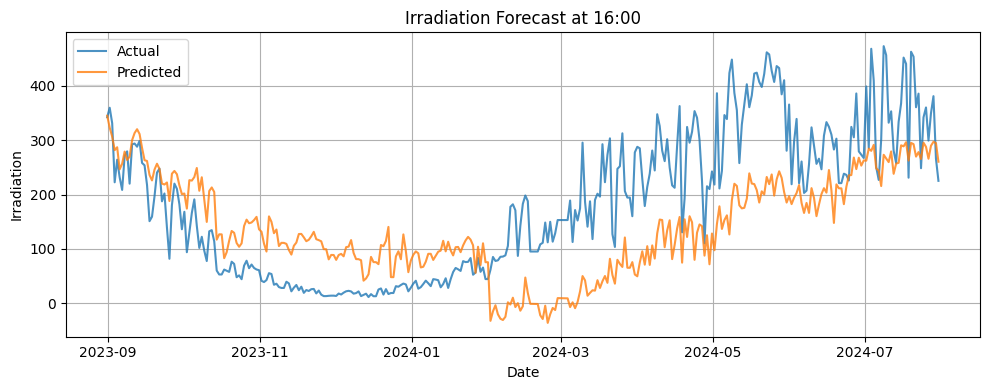


⏰ Hour: 17:00
✅ R² Score: -0.0762, RMSE: 82.95, MAE: 66.88


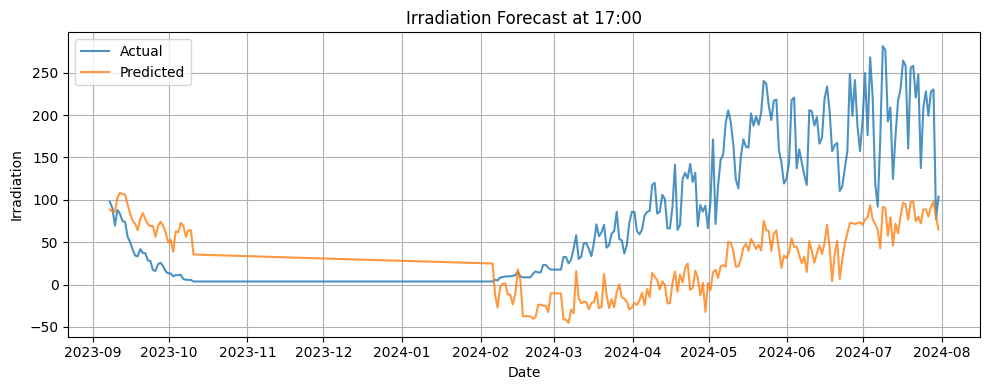


📋 Summary of Hourly ARIMAX Model Performance:
    Hour        R2        RMSE         MAE
0      6 -1.324982  171.878556  148.462440
1      7 -1.701173  257.672940  203.170896
2      8 -0.367800  196.102487  154.000690
3      9 -0.731778  241.843124  180.452939
4     10 -0.145825  203.617485  155.282731
5     11 -1.446881  318.456142  240.890964
6     12  0.111193  198.265064  160.435817
7     13 -1.747650  340.469150  293.815595
8     14  0.573258  118.264207   91.436693
9     15 -0.214521  178.892884  137.001640
10    16  0.235810  114.704372   96.791657
11    17 -0.076164   82.950651   66.878250

📅 Combined Future Forecast (Next 7 Days for all hours):
              Datetime  Forecast_Irradiation  Hour
0  2024-07-31 06:00:00            188.798860     6
1  2024-08-01 06:00:00            189.777895     6
2  2024-08-02 06:00:00            182.668484     6
3  2024-08-03 06:00:00            183.912816     6
4  2024-08-04 06:00:00            185.392682     6
..                 ...         

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Load data (assuming df is already loaded and preprocessed from previous cells)
# df = pd.read_csv("Data.csv")

# Preprocess (assuming these steps are handled in previous cells based on notebook state)
# df = df[df["Irradiation"] >= 0]
# df.replace(-999, np.nan, inplace=True)
# df["Datetime"] = pd.to_datetime(df[["Year", "Month", "Day", "Hour"]])


# Features for exogenous variables
# Using columns available in the latest df state and relevant for the model
exog_columns = ["Temperature", "RH", "Pressure", "Wind_Speed", "Precipitation"]


# Store metrics and future forecasts
results = []
future_forecasts = [] # Initialize future_forecasts list here

# Loop over each hour from 6 to 17
for hour in range(6, 18):
    print(f"\n⏰ Hour: {hour}:00")

    # Filter data for this hour only
    hourly_df = df[df["Hour"] == hour].copy()

    if len(hourly_df) < 365:
        print("⚠️ Not enough data for modeling. Skipping...")
        continue

    # Create datetime column before handling duplicates and setting index
    hourly_df["Datetime"] = pd.to_datetime(hourly_df[["Year", "Month", "Day", "Hour"]])

    # Handle potential duplicates before setting index and reindexing
    hourly_df = hourly_df.drop_duplicates(subset=['Datetime'])

    hourly_df.set_index("Datetime", inplace=True)
    hourly_df = hourly_df.sort_index().asfreq("D").fillna(method="ffill")


    # Split target and features
    y = hourly_df["Irradiation"]
    # Ensure exog columns exist in the filtered hourly_df
    current_exog_columns = [col for col in exog_columns if col in hourly_df.columns]
    X = hourly_df[current_exog_columns]


    # Train-test split
    split_idx = int(len(hourly_df) * 0.8)
    y_train, y_test = y[:split_idx], y[split_idx:]
    X_train, X_test = X[:split_idx], X[split_idx:]

    # Fit ARIMAX model
    try:
        model = SARIMAX(y_train,
                        exog=X_train,
                        order=(2, 0, 2),
                        seasonal_order=(1, 0, 1, 7),  # weekly pattern
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        model_fit = model.fit(disp=False)

        # Forecast
        y_pred = model_fit.forecast(steps=len(y_test), exog=X_test)

        # Metrics
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)

        print(f"✅ R² Score: {r2:.4f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}")

        # Store results
        results.append({
            "Hour": hour,
            "R2": r2,
            "RMSE": rmse,
            "MAE": mae
        })

        # Future 7-day forecast (integrate code from cell sWDeVliN3vOb here)
        if not X.empty and not y.empty: # Check if X and y are not empty before fitting future model
            last_exog = X.iloc[-1:]
            # Create future exogenous data by repeating the last available exogenous data for 7 days
            future_exog = pd.concat([last_exog] * 7, ignore_index=True)
            # Set the index of future_exog to match the future dates for forecasting
            future_dates_for_exog = pd.date_range(start=y.index[-1] + pd.Timedelta(days=1), periods=7, freq=hourly_df.index.freq)
            future_exog.index = future_dates_for_exog


            future_model = SARIMAX(y,
                                   exog=X,
                                   order=(2, 0, 2),
                                   seasonal_order=(1, 0, 1, 7),
                                   enforce_stationarity=False,
                                   enforce_invertibility=False)
            future_fit = future_model.fit(disp=False)
            future_pred = future_fit.forecast(steps=7, exog=future_exog)

            # Create DataFrame for future forecast and store
            future_dates = pd.date_range(start=y.index[-1] + pd.Timedelta(days=1), periods=7, freq=hourly_df.index.freq)
            forecast_df = pd.DataFrame({
                "Datetime": future_dates,
                "Forecast_Irradiation": future_pred,
                "Hour": hour
            })
            forecast_df.to_csv(f"arimax_hour_{hour}_future.csv", index=False)
            future_forecasts.append(forecast_df)
        else:
            print(f"⚠️ Skipping future forecast for hour {hour} due to empty data.")


        # Optional plot (integrate code from cell XPsla9-b362e here)
        plt.figure(figsize=(10, 4))
        plt.plot(y_test.index, y_test, label="Actual", alpha=0.8)
        plt.plot(y_test.index, y_pred, label="Predicted", alpha=0.8)
        plt.title(f"Irradiation Forecast at {hour}:00")
        plt.xlabel("Date")
        plt.ylabel("Irradiation")
        plt.legend()
        plt.tight_layout()
        plt.grid(True)
        plt.show()

    except Exception as e:
        print(f"❌ Model failed for hour {hour}. Error: {e}")
        continue

# Final summary table
results_df = pd.DataFrame(results)
print("\n📋 Summary of Hourly ARIMAX Model Performance:")
print(results_df)

# Concatenate all future forecasts
if future_forecasts:
    all_future_forecasts_df = pd.concat(future_forecasts, ignore_index=True)
    print("\n📅 Combined Future Forecast (Next 7 Days for all hours):")
    print(all_future_forecasts_df)
else:
    print("\n📅 No future forecasts were generated.")